In [7]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import logging
from scipy import sparse

# Set up logging configuration
logging.basicConfig(
    filename='../logs/data_preprocessing1.log',  
    level=logging.INFO,                         
    format='%(asctime)s - %(levelname)s - %(message)s',  
)

logging.info('Starting unsupervised learning data preprocessing.')

# Define the path to your data folder
data_path = "../data/"

# Load only the first 1000 rows of each dataset
try:
    dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=10000)
    fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=10000)
    gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=10000)
    rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=10000)
    logging.info('Datasets loaded successfully with the first 1000 rows from each file.')
except Exception as e:
    logging.error(f"Error loading datasets: {e}")

# Combine datasets into a single DataFrame
combined_data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], ignore_index=True)
logging.info('Datasets combined successfully.')

# Separate numeric and categorical columns
numeric_columns = combined_data.select_dtypes(include=['number']).columns
categorical_columns = combined_data.select_dtypes(exclude=['number']).columns

logging.info(f"Numeric columns: {numeric_columns}")
logging.info(f"Categorical columns: {categorical_columns}")

# Handle categorical data using One-Hot Encoding with sparse matrix output
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=True, drop='first')  # Keep output sparse to reduce memory usage
    categorical_encoded = encoder.fit_transform(combined_data[categorical_columns])
    
    # Convert numeric data into a sparse format
    numeric_data = combined_data[numeric_columns]
    numeric_data_sparse = sparse.csr_matrix(numeric_data.values)
    
    # Concatenate sparse categorical and numeric data
    combined_data_sparse = sparse.hstack([numeric_data_sparse, categorical_encoded])
    logging.info('Categorical columns encoded using One-Hot Encoding (sparse format).')
else:
    combined_data_sparse = sparse.csr_matrix(combined_data[numeric_columns].values)
    logging.info('No categorical columns to encode.')

# Normalize the numeric data (can only apply normalization to the numeric columns)
scaler = StandardScaler(with_mean=False)  # with_mean=False is needed for sparse matrices
numeric_data_scaled = scaler.fit_transform(combined_data[numeric_columns])

# Convert scaled numeric data to sparse matrix and concatenate with the sparse categorical data
numeric_data_scaled_sparse = sparse.csr_matrix(numeric_data_scaled)
combined_data_encoded = sparse.hstack([numeric_data_scaled_sparse, categorical_encoded])

# Convert the sparse matrix to a dense format for PyTorch tensor (for training)
X_dense = combined_data_encoded.toarray()

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_dense, dtype=torch.float32)
logging.info('Data converted to PyTorch tensors.')

# Create DataLoader for batch processing
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
logging.info(f'DataLoader created with batch size of 64. Total batches: {len(data_loader)}')

# Print summary and log completion
print(f"Number of data points: {len(X_tensor)}")
print(f"Number of batches in DataLoader: {len(data_loader)}")
logging.info('Data preprocessing completed successfully.')


Number of data points: 40000
Number of batches in DataLoader: 625


In [9]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.model_selection import train_test_split
import logging

# Set up logging configuration
logging.basicConfig(
    filename='../logs/data_preprocessing_anomaly_detection.log',  
    level=logging.INFO,                         
    format='%(asctime)s - %(levelname)s - %(message)s',  
)

logging.info('Starting data preprocessing for anomaly detection.')

# Define the path to your data folder
data_path = "../data/"

# Load only the first 1000 rows of each dataset
try:
    dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=20000)
    fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=20000)
    gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=20000)
    rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=20000)
    logging.info('Datasets loaded successfully with the first 1000 rows from each file.')
except Exception as e:
    logging.error(f"Error loading datasets: {e}")

# Combine datasets into a single DataFrame
combined_data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], ignore_index=True)
logging.info('Datasets combined successfully.')

# Separate numeric and categorical columns
numeric_columns = combined_data.select_dtypes(include=['number']).columns
categorical_columns = combined_data.select_dtypes(exclude=['number']).columns

logging.info(f"Numeric columns: {numeric_columns}")
logging.info(f"Categorical columns: {categorical_columns}")

# Handle categorical data using One-Hot Encoding with sparse matrix output
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=True, drop='first')  # Keep output sparse to reduce memory usage
    categorical_encoded = encoder.fit_transform(combined_data[categorical_columns])
    
    # Convert numeric data into a sparse format
    numeric_data = combined_data[numeric_columns]
    numeric_data_sparse = sparse.csr_matrix(numeric_data.values)
    
    # Concatenate sparse categorical and numeric data
    combined_data_sparse = sparse.hstack([numeric_data_sparse, categorical_encoded])
    logging.info('Categorical columns encoded using One-Hot Encoding (sparse format).')
else:
    combined_data_sparse = sparse.csr_matrix(combined_data[numeric_columns].values)
    logging.info('No categorical columns to encode.')

# Normalize the numeric data (can only apply normalization to the numeric columns)
scaler = StandardScaler(with_mean=False)  # with_mean=False is needed for sparse matrices
numeric_data_scaled = scaler.fit_transform(combined_data[numeric_columns])
logging.info('Numeric data normalized using StandardScaler.')

# Convert scaled numeric data to sparse matrix and concatenate with the sparse categorical data
numeric_data_scaled_sparse = sparse.csr_matrix(numeric_data_scaled)
combined_data_encoded = sparse.hstack([numeric_data_scaled_sparse, categorical_encoded])

# Convert the sparse matrix to a dense format for PyTorch tensor (for training)
X_dense = combined_data_encoded.toarray()
logging.info('Data concatenated and converted to dense format for PyTorch.')

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_dense, dtype=torch.float32)
logging.info('Data converted to PyTorch tensors.')

# Step 1: Train-Test Split
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)
logging.info(f"Data split into training and test sets with a test size of 20%.")

# Create DataLoaders for both training and test sets
train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
logging.info('DataLoader created for both training and test sets.')

# Step 2: Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid to ensure outputs are between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder model
input_dim = X_tensor.shape[1]  # Number of input features
autoencoder = Autoencoder(input_dim)
logging.info(f"Autoencoder model initialized with input dimension: {input_dim}.")

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
logging.info('Loss function and optimizer set up.')

# Train the Autoencoder
n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        
        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # Compare output with input
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    logging.info(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')

logging.info('Training complete.')

# Step 4: Anomaly Detection
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    with torch.no_grad():  # No need to compute gradients in evaluation
        for data in data_loader:
            inputs = data[0]
            outputs = model(inputs)
            reconstruction_error = torch.mean((outputs - inputs) ** 2, dim=1)
            # If reconstruction error is above the threshold, flag as anomaly
            anomalies += (reconstruction_error > threshold).cpu().numpy().tolist()
    
    return anomalies

# Set a threshold for anomaly detection
threshold = 0.02
logging.info(f"Anomaly detection threshold set to {threshold}.")

# Detect anomalies in the test set
anomalies = detect_anomalies(test_loader, autoencoder, threshold)

# Print the number of detected anomalies
num_anomalies = sum(anomalies)
print(f"Number of anomalies detected: {num_anomalies}")
logging.info(f"Number of anomalies detected: {num_anomalies}")


Epoch [1/50], Loss: nan
Epoch [2/50], Loss: nan
Epoch [3/50], Loss: nan
Epoch [4/50], Loss: nan
Epoch [5/50], Loss: nan
Epoch [6/50], Loss: nan
Epoch [7/50], Loss: nan
Epoch [8/50], Loss: nan
Epoch [9/50], Loss: nan
Epoch [10/50], Loss: nan
Epoch [11/50], Loss: nan
Epoch [12/50], Loss: nan
Epoch [13/50], Loss: nan
Epoch [14/50], Loss: nan
Epoch [15/50], Loss: nan
Epoch [16/50], Loss: nan
Epoch [17/50], Loss: nan
Epoch [18/50], Loss: nan
Epoch [19/50], Loss: nan
Epoch [20/50], Loss: nan
Epoch [21/50], Loss: nan
Epoch [22/50], Loss: nan
Epoch [23/50], Loss: nan
Epoch [24/50], Loss: nan
Epoch [25/50], Loss: nan
Epoch [26/50], Loss: nan
Epoch [27/50], Loss: nan
Epoch [28/50], Loss: nan
Epoch [29/50], Loss: nan
Epoch [30/50], Loss: nan
Epoch [31/50], Loss: nan
Epoch [32/50], Loss: nan
Epoch [33/50], Loss: nan
Epoch [34/50], Loss: nan
Epoch [35/50], Loss: nan
Epoch [36/50], Loss: nan
Epoch [37/50], Loss: nan
Epoch [38/50], Loss: nan
Epoch [39/50], Loss: nan
Epoch [40/50], Loss: nan
Epoch [41

Epoch [1/50], Loss: nan
Epoch [2/50], Loss: nan
Epoch [3/50], Loss: nan
Epoch [4/50], Loss: nan
Epoch [5/50], Loss: nan
Epoch [6/50], Loss: nan
Epoch [7/50], Loss: nan
Epoch [8/50], Loss: nan
Epoch [9/50], Loss: nan
Epoch [10/50], Loss: nan
Epoch [11/50], Loss: nan
Epoch [12/50], Loss: nan
Epoch [13/50], Loss: nan
Epoch [14/50], Loss: nan
Epoch [15/50], Loss: nan
Epoch [16/50], Loss: nan
Epoch [17/50], Loss: nan
Epoch [18/50], Loss: nan
Epoch [19/50], Loss: nan
Epoch [20/50], Loss: nan
Epoch [21/50], Loss: nan
Epoch [22/50], Loss: nan
Epoch [23/50], Loss: nan
Epoch [24/50], Loss: nan
Epoch [25/50], Loss: nan
Epoch [26/50], Loss: nan
Epoch [27/50], Loss: nan
Epoch [28/50], Loss: nan
Epoch [29/50], Loss: nan
Epoch [30/50], Loss: nan
Epoch [31/50], Loss: nan
Epoch [32/50], Loss: nan
Epoch [33/50], Loss: nan
Epoch [34/50], Loss: nan
Epoch [35/50], Loss: nan
Epoch [36/50], Loss: nan
Epoch [37/50], Loss: nan
Epoch [38/50], Loss: nan
Epoch [39/50], Loss: nan
Epoch [40/50], Loss: nan
Epoch [41

C:\Users\11549\AppData\Local\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\11549\AppData\Local\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

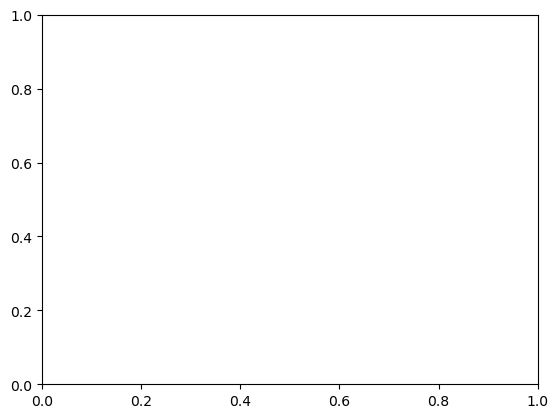

In [5]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt

# Set up logging configuration
logging.basicConfig(
    filename='../logs/data_preprocessing_anomaly_detection.log',  
    level=logging.INFO,                         
    format='%(asctime)s - %(levelname)s - %(message)s',  
)

logging.info('Starting data preprocessing for anomaly detection.')

# Define the path to your data folder
data_path = "../data/"

# Load only the first 1000 rows of each dataset
try:
    dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000)
    fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=1000)
    gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
    rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)
    logging.info('Datasets loaded successfully with the first 1000 rows from each file.')
except Exception as e:
    logging.error(f"Error loading datasets: {e}")

# Combine datasets into a single DataFrame
combined_data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], ignore_index=True)
logging.info('Datasets combined successfully.')

# Separate numeric and categorical columns
numeric_columns = combined_data.select_dtypes(include=['number']).columns
categorical_columns = combined_data.select_dtypes(exclude=['number']).columns

logging.info(f"Numeric columns: {numeric_columns}")
logging.info(f"Categorical columns: {categorical_columns}")

# Handle categorical data using One-Hot Encoding with sparse matrix output
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=True, drop='first')  # Keep output sparse to reduce memory usage
    categorical_encoded = encoder.fit_transform(combined_data[categorical_columns])
    
    # Convert numeric data into a sparse format
    numeric_data = combined_data[numeric_columns]
    numeric_data_sparse = sparse.csr_matrix(numeric_data.values)
    
    # Concatenate sparse categorical and numeric data
    combined_data_sparse = sparse.hstack([numeric_data_sparse, categorical_encoded])
    logging.info('Categorical columns encoded using One-Hot Encoding (sparse format).')
else:
    combined_data_sparse = sparse.csr_matrix(combined_data[numeric_columns].values)
    logging.info('No categorical columns to encode.')

# Normalize the numeric data (can only apply normalization to the numeric columns)
scaler = StandardScaler(with_mean=False)  # with_mean=False is needed for sparse matrices
numeric_data_scaled = scaler.fit_transform(combined_data[numeric_columns])
logging.info('Numeric data normalized using StandardScaler.')

# Convert scaled numeric data to sparse matrix and concatenate with the sparse categorical data
numeric_data_scaled_sparse = sparse.csr_matrix(numeric_data_scaled)
combined_data_encoded = sparse.hstack([numeric_data_scaled_sparse, categorical_encoded])

# Convert the sparse matrix to a dense format for PyTorch tensor (for training)
X_dense = combined_data_encoded.toarray()
logging.info('Data concatenated and converted to dense format for PyTorch.')

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_dense, dtype=torch.float32)
logging.info('Data converted to PyTorch tensors.')

# Step 1: Train-Test Split
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)
logging.info(f"Data split into training and test sets with a test size of 20%.")

# Create DataLoaders for both training and test sets
train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
logging.info('DataLoader created for both training and test sets.')

# Step 2: Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid to ensure outputs are between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder model
input_dim = X_tensor.shape[1]  # Number of input features
autoencoder = Autoencoder(input_dim)
logging.info(f"Autoencoder model initialized with input dimension: {input_dim}.")

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
logging.info('Loss function and optimizer set up.')

# Train the Autoencoder
n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        
        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # Compare output with input
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    logging.info(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')

logging.info('Training complete.')

# Step 4: Anomaly Detection
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    with torch.no_grad():  # No need to compute gradients in evaluation
        for data in data_loader:
            inputs = data[0]
            outputs = model(inputs)
            
            # Compute reconstruction error (MSE between inputs and outputs)
            reconstruction_error = torch.mean((outputs - inputs) ** 2, dim=1)
            
            # Flag as anomaly if reconstruction error exceeds the threshold
            anomalies += (reconstruction_error > threshold).cpu().numpy().tolist()
    
    return anomalies

# Set a threshold for anomaly detection
threshold = 0.02  # Adjust this value based on your data and testing
logging.info(f"Anomaly detection threshold set to {threshold}.")

# Detect anomalies in the test set
anomalies = detect_anomalies(test_loader, autoencoder, threshold)
num_anomalies = sum(anomalies)
print(f"Number of anomalies detected: {num_anomalies}")
logging.info(f"Number of anomalies detected: {num_anomalies}")

# Plot reconstruction errors (optional for better visualization)
def plot_reconstruction_errors(data_loader, model):
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0]
            outputs = model(inputs)
            reconstruction_error = torch.mean((outputs - inputs) ** 2, dim=1)
            reconstruction_errors += reconstruction_error.cpu().numpy().tolist()
    
    # Plot histogram of reconstruction errors
    plt.hist(reconstruction_errors, bins=50)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Data Points')
    plt.title('Reconstruction Errors of Test Data')
    plt.show()

# Call the function to plot errors
plot_reconstruction_errors(test_loader, autoencoder)

# Tuning the threshold based on the results
threshold = 0.01  # Adjust this if you're missing anomalies or detecting too many
anomalies = detect_anomalies(test_loader, autoencoder, threshold)
print(f"Number of anomalies detected after tuning: {sum(anomalies)}")
logging.info(f"Number of anomalies detected after tuning: {sum(anomalies)}")


In [10]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import numpy as np

# Function to set up logging
def setup_logging(debug=False):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    
    file_handler = logging.FileHandler('../logs/data_preprocessing_anomaly_detection.log')
    file_handler.setLevel(logging.INFO)
    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    
    logger.addHandler(file_handler)

    if debug:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(logging.INFO)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)
    else:
        logger.info("Console logging is disabled; only logging to file.")

setup_logging(debug=False)  # Set to True to enable console logging, False for file only

logging.info('Starting data preprocessing for anomaly detection.')

# Define the path to your data folder
data_path = "../data/"

# Load only the first 1000 rows of each dataset
try:
    dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=51000)
    fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=51000)
    gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=51000)
    rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=51000)
    logging.info('Datasets loaded successfully with the first 1000 rows from each file.')
except Exception as e:
    logging.error(f"Error loading datasets: {e}")

# Combine datasets into a single DataFrame
combined_data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], ignore_index=True)
logging.info('Datasets combined successfully.')

# Separate numeric and categorical columns
numeric_columns = combined_data.select_dtypes(include=['number']).columns
categorical_columns = combined_data.select_dtypes(exclude=['number']).columns

logging.info(f"Numeric columns: {numeric_columns}")
logging.info(f"Categorical columns: {categorical_columns}")

# Handle categorical data using One-Hot Encoding with sparse matrix output
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(sparse_output=True, drop='first')  # Keep output sparse to reduce memory usage
    categorical_encoded = encoder.fit_transform(combined_data[categorical_columns])
    
    # Convert numeric data into a sparse format
    numeric_data = combined_data[numeric_columns]
    numeric_data_sparse = sparse.csr_matrix(numeric_data.values)
    
    # Concatenate sparse categorical and numeric data
    combined_data_sparse = sparse.hstack([numeric_data_sparse, categorical_encoded])
    logging.info('Categorical columns encoded using One-Hot Encoding (sparse format).')
else:
    combined_data_sparse = sparse.csr_matrix(combined_data[numeric_columns].values)
    logging.info('No categorical columns to encode.')

# Normalize the numeric data (can only apply normalization to the numeric columns)
scaler = StandardScaler(with_mean=False)  # with_mean=False is needed for sparse matrices
numeric_data_scaled = scaler.fit_transform(combined_data[numeric_columns])
logging.info('Numeric data normalized using StandardScaler.')

# Convert scaled numeric data to sparse matrix and concatenate with the sparse categorical data
numeric_data_scaled_sparse = sparse.csr_matrix(numeric_data_scaled)
combined_data_encoded = sparse.hstack([numeric_data_scaled_sparse, categorical_encoded])

# Convert the sparse matrix to a dense format for PyTorch tensor (for training)
X_dense = combined_data_encoded.toarray()
logging.info('Data concatenated and converted to dense format for PyTorch.')

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_dense, dtype=torch.float32)
logging.info('Data converted to PyTorch tensors.')

# Step 1: Train-Test Split
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)
logging.info(f"Data split into training and test sets with a test size of 20%.")

# Create DataLoaders for both training and test sets
train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
logging.info('DataLoader created for both training and test sets.')

# Step 2: Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid to ensure outputs are between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder model
input_dim = X_tensor.shape[1]  # Number of input features
autoencoder = Autoencoder(input_dim)
logging.info(f"Autoencoder model initialized with input dimension: {input_dim}.")

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
logging.info('Loss function and optimizer set up.')

# Train the Autoencoder
n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        
        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # Compare output with input
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    logging.info(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader)}')

logging.info('Training complete.')

# Step 4: Anomaly Detection
def detect_anomalies(data_loader, model, threshold):
    model.eval()
    anomalies = []
    reconstruction_errors = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0]
            outputs = model(inputs)
            reconstruction_error = torch.mean((outputs - inputs) ** 2, dim=1)
            anomalies += (reconstruction_error > threshold).cpu().numpy().tolist()
            reconstruction_errors += reconstruction_error.cpu().numpy().tolist()
    
    return anomalies, reconstruction_errors

# Updated function to handle NaN values in reconstruction errors
def plot_reconstruction_errors(data_loader, model):
    model.eval()
    _, reconstruction_errors = detect_anomalies(data_loader, model, threshold=0.02)
    reconstruction_errors = np.array(reconstruction_errors)
    
    # Remove NaN values before plotting
    clean_reconstruction_errors = reconstruction_errors[~np.isnan(reconstruction_errors)]
    
    if len(clean_reconstruction_errors) == 0:
        print("No valid reconstruction errors to plot.")
        logging.warning("All reconstruction errors were NaN.")
        return
    
    # Plot histogram of reconstruction errors
    plt.hist(clean_reconstruction_errors, bins=50)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Data Points')
    plt.title('Reconstruction Errors of Test Data')
    plt.show()

# Call the function to plot errors after handling NaN values
plot_reconstruction_errors(test_loader, autoencoder)

# Tuning the threshold based on the results
threshold = 0.01  # Adjust this if you're missing anomalies or detecting too many
anomalies = detect_anomalies(test_loader, autoencoder, threshold)[0]
print(f"Number of anomalies detected after tuning: {sum(anomalies)}")
logging.info(f"Number of anomalies detected after tuning: {sum(anomalies)}")


MemoryError: Unable to allocate 9.06 GiB for an array with shape (204000, 5960) and data type float64

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=51000)
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=51000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=51000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=51000)
print("data loade")

# Concatenate datasets for training
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)

# Data preprocessing: Normalizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)  # Normalize the data

# Convert data to PyTorch tensors
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_scaled.shape[1]  # Number of features (columns)
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Anomaly Detection: Detect anomalies based on reconstruction error
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
    return anomalies

# Set a threshold based on training loss (you can adjust this threshold)
threshold = 0.02  # Example threshold, fine-tune based on your data
anomalies = detect_anomalies(dataloader, model, threshold)

# Display the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=51000)
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=51000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=51000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=51000)
print("data loade")

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed.toarray(), dtype=torch.float32) if isinstance(data_preprocessed, pd.DataFrame) else torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Anomaly Detection: Detect anomalies based on reconstruction error
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
    return anomalies

# Set a threshold based on training loss (you can adjust this threshold)
threshold = 0.02  # Example threshold, fine-tune based on your data
anomalies = detect_anomalies(dataloader, model, threshold)

# Display the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=20000)
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=20000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=20000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=20000)
print("data loade")

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Anomaly Detection: Detect anomalies based on reconstruction error
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
    return anomalies

# Set a threshold based on training loss (you can adjust this threshold)
threshold = 0.02  # Example threshold, fine-tune based on your data
anomalies = detect_anomalies(dataloader, model, threshold)

# Display the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=1000)
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=1000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=1000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=1000)
print("data loade")
1
# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Anomaly Detection: Detect anomalies based on reconstruction error
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
    return anomalies

# Set a threshold based on training loss (you can adjust this threshold)
threshold = 0.02  # Example threshold, fine-tune based on your data
anomalies = detect_anomalies(dataloader, model, threshold)

# Display the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
data_path = "../data/"

# Load only the first 1000 rows of each dataset

dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=50000)
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'), nrows=50000)
# gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=50000)
# rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=50000)


# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Anomaly Detection: Detect anomalies based on reconstruction error
def detect_anomalies(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
    return anomalies

# Set a threshold based on training loss (you can adjust this threshold)
threshold = 0.02  # Example threshold, fine-tune based on your data
anomalies = detect_anomalies(dataloader, model, threshold)

# Display the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import os
import torch.optim as optim

# Load the datasets
data_path = "../data/"

# Load only the first 1000 rows of each dataset

dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=10000) 
# fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=0000)
# gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=50000)
# rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=50000)

# Concatenate datasets
data = pd.concat([dos_data,], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    return reconstruction_errors

# Step 2: Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Step 3: Plot the reconstruction error distribution to help set the threshold
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.title('Distribution of Reconstruction Errors')
plt.show()

# Step 4: Dynamically calculate the threshold based on the mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set threshold as mean + 2 standard deviations
threshold = mean_error + 2 * std_error
print(f"Dynamically calculated threshold based on data: {threshold}")

# You can also choose to use the 95th percentile as an alternative:
# threshold = np.percentile(reconstruction_errors, 95)
# print(f"Threshold based on 95th percentile: {threshold}")

# Function to detect anomalies and get their corresponding row indices
def detect_anomalies_with_indices(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    anomaly_indices = []  # List to store indices of the anomalies
    idx = 0  # Index counter for the data rows
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)  # Store the index of the anomaly
        idx += 1  # Increment index counter
    return anomalies, anomaly_indices

# Detect anomalies and get their indices
anomalies, anomaly_indices = detect_anomalies_with_indices(dataloader, model, threshold)

# Print the number of anomalies detected and their corresponding row indices
print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Anomalies detected at rows (indices): {anomaly_indices}")


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the datasets
data_path = "../data/"

# Load only the first 1000 rows of each dataset

dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=10000) 
# fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=0000)
# gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=50000)
# rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=50000)

# Concatenate datasets
data = pd.concat([dos_data], axis=0)

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Preprocessed Data Shape: {data_preprocessed.shape}")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    return reconstruction_errors

# Step 2: Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Step 3: Dynamically calculate the threshold based on the mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set threshold as mean + 2 standard deviations
threshold = mean_error + 2 * std_error
print(f"Dynamically calculated threshold based on data: {threshold}")

# Function to detect anomalies and get their corresponding row indices
def detect_anomalies_with_indices(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    anomaly_indices = []  # List to store indices of the anomalies
    idx = 0  # Index counter for the data rows
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)  # Store the index of the anomaly
        idx += 1  # Increment index counter
    return anomalies, anomaly_indices

# Detect anomalies and get their indices
anomalies, anomaly_indices = detect_anomalies_with_indices(dataloader, model, threshold)

# Print the number of anomalies detected and their corresponding row indices
print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Anomalies detected at rows (indices): {anomaly_indices}")

# ==============================
# Mitigation Section
# ==============================

# A. Log Anomalies
def log_anomalies(anomaly_indices, reconstruction_errors, data):
    # Log anomalies with details
    with open("anomaly_log.txt", "w") as log_file:
        for idx in anomaly_indices:
            log_file.write(f"Anomaly at row {idx}, Error: {reconstruction_errors[idx]}, Data: {data[idx]}\n")
    print("Anomalies logged.")

log_anomalies(anomaly_indices, reconstruction_errors, data_tensor)

# B. Alert Driver if critical anomaly is detected
def alert_driver(message):
    print(f"Driver Alert: {message}")

# If critical anomaly is detected (e.g., anomaly in sensor data, ECU data), alert driver
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}")

# C. Isolate the ECU if compromised (pseudo-code)
def isolate_ecu(ecu_id):
    print(f"ECU {ecu_id} is isolated due to suspicious activity.")
    # Implement code to disable or disconnect the ECU

# Example: Isolate a specific ECU if anomaly is related to that ECU (replace 'ecu_id' with real data)
isolate_ecu('ECU_1')

# D. Trigger Safe Mode in case of critical failure
def trigger_safe_mode():
    print("Entering safe mode due to anomaly detection...")

# Trigger safe mode for severe anomalies
if len(anomaly_indices) > 5:  # Example condition: more than 5 anomalies trigger safe mode
    trigger_safe_mode()


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import logging
import os

# ==============================
# Logging Configuration
# ==============================
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Define the format
    handlers=[
        logging.FileHandler("system_log.log"),  # Save logs to a file
        logging.StreamHandler()  # Also display logs on the console
    ]
)

# Load the datasets
data_path = "../data/"

# Load only the first 1000 rows of each dataset

dos_data = pd.read_csv(os.path.join(data_path, 'DoS_dataset.csv'), nrows=30000) 
fuzzy_data = pd.read_csv(os.path.join(data_path, 'Fuzzy_dataset.csv'),nrows=30000)
gear_data = pd.read_csv(os.path.join(data_path, 'gear_dataset.csv'), nrows=30000)
rpm_data = pd.read_csv(os.path.join(data_path, 'RPM_dataset.csv'), nrows=30000)

# Concatenate datasets
data = pd.concat([dos_data], axis=0)

# Concatenate datasets
data = pd.concat([dos_data, fuzzy_data, gear_data, rpm_data], axis=0)
logging.info(f"Data loaded and concatenated. Total rows: {data.shape[0]}, Total columns: {data.shape[1]}")

# Separate numeric and categorical columns
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Define preprocessing for numeric features (impute missing values with mean, scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())])  # Normalize the numeric features

# Define preprocessing for categorical features (impute missing values with mode, one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # One-hot encode the categorical features

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations to the data
data_preprocessed = preprocessor.fit_transform(data)
logging.info(f"Data preprocessing complete. Shape after preprocessing: {data_preprocessed.shape}")

# Convert the processed data into a PyTorch tensor
data_tensor = torch.tensor(data_preprocessed, dtype=torch.float32)

# Create DataLoader
batch_size = 64
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
logging.info(f"DataLoader created with batch size {batch_size}.")

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Encoder: Compressing input data
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        # Decoder: Reconstructing the original data
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using sigmoid to bring values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder
input_size = data_preprocessed.shape[1]  # Number of features (columns) after preprocessing
model = Autoencoder(input_size)
logging.info(f"Autoencoder initialized with input size {input_size}.")

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]  # DataLoader returns a tuple
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    logging.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Function to calculate reconstruction errors
def calculate_reconstruction_errors(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        reconstruction_errors.append(loss.item())  # Collect the reconstruction error for each batch
    logging.info("Reconstruction errors calculated.")
    return reconstruction_errors

# Step 2: Calculate reconstruction errors for the training data
reconstruction_errors = calculate_reconstruction_errors(dataloader, model)

# Step 3: Dynamically calculate the threshold based on the mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set threshold as mean + 2 standard deviations
threshold = mean_error + 2 * std_error
logging.info(f"Dynamically calculated threshold based on data: {threshold}")

# Function to detect anomalies and get their corresponding row indices
def detect_anomalies_with_indices(data_loader, model, threshold):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    anomaly_indices = []  # List to store indices of the anomalies
    idx = 0  # Index counter for the data rows
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        # If the reconstruction error exceeds the threshold, flag as anomaly
        if loss.item() > threshold:
            anomalies.append(inputs)
            anomaly_indices.append(idx)  # Store the index of the anomaly
        idx += 1  # Increment index counter
    logging.info(f"Anomalies detected at rows (indices): {anomaly_indices}")
    return anomalies, anomaly_indices

# Detect anomalies and get their indices
anomalies, anomaly_indices = detect_anomalies_with_indices(dataloader, model, threshold)

# ==============================
# Mitigation Section with Logging
# ==============================

# A. Log Anomalies
def log_anomalies(anomaly_indices, reconstruction_errors, data):
    # Log anomalies with details
    with open("anomaly_log.txt", "w") as log_file:
        for idx in anomaly_indices:
            log_file.write(f"Anomaly at row {idx}, Error: {reconstruction_errors[idx]}, Data: {data[idx]}\n")
    logging.info("Anomalies logged.")

log_anomalies(anomaly_indices, reconstruction_errors, data_tensor)

# B. Alert Driver if critical anomaly is detected
def alert_driver(message):
    logging.warning(f"Driver Alert: {message}")

# If critical anomaly is detected (e.g., anomaly in sensor data, ECU data), alert driver
for idx in anomaly_indices:
    alert_driver(f"Critical anomaly detected at row {idx}")

# C. Isolate the ECU if compromised (pseudo-code)
def isolate_ecu(ecu_id):
    logging.error(f"ECU {ecu_id} is isolated due to suspicious activity.")

# Example: Isolate a specific ECU if anomaly is related to that ECU (replace 'ecu_id' with real data)
isolate_ecu('ECU_1')

# D. Trigger Safe Mode in case of critical failure
def trigger_safe_mode():
    logging.critical("Entering safe mode due to anomaly detection...")

# Trigger safe mode for severe anomalies
if len(anomaly_indices) > 5:  # Example condition: more than 5 anomalies trigger safe mode
    trigger_safe_mode()


2024-09-19 11:59:08,110 - INFO - Data loaded and concatenated. Total rows: 120000, Total columns: 32
2024-09-19 11:59:21,522 - INFO - Data preprocessing complete. Shape after preprocessing: (120000, 5569)
2024-09-19 11:59:22,725 - INFO - DataLoader created with batch size 64.
2024-09-19 11:59:22,795 - INFO - Autoencoder initialized with input size 5569.
2024-09-19 11:59:55,244 - INFO - Epoch 1/50, Loss: 0.002494103740900755
2024-09-19 12:00:25,075 - INFO - Epoch 2/50, Loss: 0.0017179318238049746
2024-09-19 12:01:01,693 - INFO - Epoch 3/50, Loss: 0.0016020906623452902
2024-09-19 12:02:15,799 - INFO - Epoch 4/50, Loss: 0.001316692098043859
2024-09-19 12:03:51,265 - INFO - Epoch 5/50, Loss: 0.0015014332020655274
2024-09-19 12:05:15,804 - INFO - Epoch 6/50, Loss: 0.0018789664609357715
2024-09-19 12:06:57,066 - INFO - Epoch 7/50, Loss: 0.0015660455683246255
2024-09-19 12:08:22,567 - INFO - Epoch 8/50, Loss: 0.0016733399825170636
2024-09-19 12:09:39,459 - INFO - Epoch 9/50, Loss: 0.001599750